# Computational Methods for Astrophysics, Homework #1, Askold Vilkha

In [1]:
#loading libraries
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.utilities import lambdify

## Exercise 1, Lagrange Interpolation

In this problem, we are working with *Runge's function*:
$$ f(x) = \frac{1}{1 + 25 x^2}$$
The plot for it is shown in Fig. 1 below.

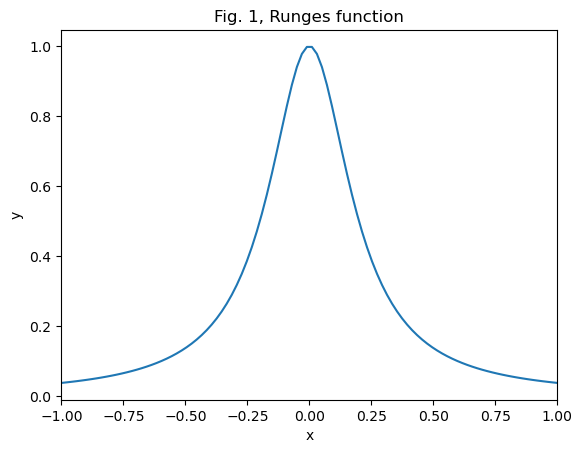

In [2]:
x = np.linspace(-1, 1, 100)
plt.plot(x, 1 / (1 + 25 * x ** 2))
plt.xlim(-1, 1)
plt.xlabel(r'x'); plt.ylabel(r'y')
plt.title(r'Fig. 1, Runges function');

We are using *Lagrange interpolation* method here. The general idea of this method is that given a list of $x_i$ and $y_i$ points, we can build a polynomial that will go through these points and will predict the function behavior, at the points in between. In other words, if we have tabulated some function $y = f(x)$ over points $(x_0,\, x_1, \dots, x_i, \dots, x_n)$, we can estimate values of $y$ that are not tabulated for some value of $x$, using Lagrange polynomial.

The polynomial has the following form:
$$P_n(x) = \sum_{i = 0}^n y_i \prod_{j=0, j\neq i}^n \frac{x - x_j}{x_i - x_j}$$
Indices $i$ and $j$ represent the points, at which function is tabulated, however, we do not have to use all of these points. We can just use $n$ closest points, depending on how much precision we need, or how computationally heavy we want the interpolation to be. If we use more points, the interpolation will be more accurate but also will take more computational resources and vice versa. We will call that set of points around a test point a *stencil*. It is important to avoid double counting at $i$ and $j$ to avoid zeros in the denominator. 

For this problem, we are going to use a stencil of 4 points. However, the numeric function for that will allow user to choose as many stencil points as they wish. We are interpolating Runge's function at the interval $[-1, 1]$. This is `runge_func` in code. In this interval, user may choose the number of points at which the function is tabulated. Specific points are calculated using the following expression: 
$$x_j = -1 + \frac{2j}{N - 1}$$ 
(Function `interp_points`) \
After, we define an array of test $x$ values, over which we will try to interpolate the function. This array has to start at $x = -1$ and end at $x = 1$. In the main algorithm, function `stencil_locator` will find 4 closest tabulated points to a test value $x$ and use them to build a polynomial at this point. The algorithm is implemented in `interp_polynom_lagrange`. Function `interp_lagrange` plots the error vs $x$ for a number of tabulation points and stencil points inputted by user. 

In [3]:
def runge_func(x):
    '''
    Function with the Runge's function
    '''
    return 1 / (1 + 25 * x ** 2)

In [4]:
def interp_points(N_points: int): 
    '''
    Function with the formula to find x points for the interpolation table \n
    Input: N_points (int) - number of points, must not be negative \n
    Output: x_j (np.array) - array of evaluated x_j values
    '''
    if N_points < 0:
        raise ValueError(N_points, r'Number of points N_points must not be negative!')
    
    x_j = np.zeros(N_points)
    for j in range(N_points):
        x_j[j] = -1 + 2 * j / (N_points - 1)
    return x_j

In [5]:
def stencil_locator(stencil_points: int, x_table, x_test: float):
    '''
    Function that locates the desired number of stencil points given a table of points and a test array of points \n
    Input: stencil_points (int) - number of stencil points the user needs (in our case it's 4) \\
    x_table (np.array) - array that contains the table of x points for interpolation \\
    x_test (float) - test point for which we want to find the closest points \n
    Output: points_ind (np.array) - array containing the indices of the closest points to x_test in x_table
    '''
    if stencil_points < 0:
        raise ValueError(stencil_points, r'Number of stencil points stencil_points must not be negative!')
    if (x_test < -1) or (x_test > 1):
        raise ValueError(x, r'Variable x_test must be in the interval [-1, 1]!')

    dist = np.abs(x_test - x_table) #array containing the distance from the test point to each of the table points
    points_ind = np.argsort(dist)[:stencil_points]
    return points_ind

In [6]:
def interp_polynom_lagrange(x_test, x_table, y_table, stencil_points: int):
    '''
    Function that contains the main Lagrange interpolation algorithm \n
    Input: x_test (np.array) - array of x values, for which we are going to interpolate the function \\
    x_table (np.array) - array of x points at which the function is tabulated \\
    y_table (np.array) - array of tabulated y points of the function \\
    stencil_points (int) - number of points taken from the table around a test point \n
    Output: polynom (np.array) - resulting interpolation polynom 
    '''
    polynom = np.zeros_like(x_test)
    for k in range(len(x_test)):
        polynom_temp = np.zeros(stencil_points)
        stencil = stencil_locator(stencil_points, x_table, x_test[k])
        for i in stencil:
            for j in stencil:
                stencil_corr = np.delete(stencil, np.where(stencil == i)) #this stencil will skip the point where i and j are the same, so avoid division by zero
                prod_frac_up = x_test[k] - x_table[stencil_corr] #array consisting of the values of x point minus the point from the interpolation table
                prod_frac_down = x_table[i] - x_table[stencil_corr] #array of differences of the x points from the interpolation table
                prod_temp = np.prod(prod_frac_up / prod_frac_down)
                polynom_temp[i-min(stencil)] = y_table[i] * prod_temp #polynom_temp is an array of stencil_points size, we have to start indexing from zero, so we don't get out of bounds
        polynom[k] = np.sum(polynom_temp)
    return polynom


In [7]:
def interp_lagrange(npoints: int, stencil_points: int = 4):
    '''
    Function that calls Lagrange interpolation and plots the error \n
    Input: npoints (int) - number of points for interpolation table \\
    stencil_points (int) (optional) - number of points taken from the table around a test point, default 4, must not be negative!
    '''
    x_table = interp_points(npoints); y_table = runge_func(x_table)
    x_test = np.linspace(-1, 1, 2 * npoints) #we will use at least twice the number of points in the interpolation table, so interpolation makes sense
    interp_res = interp_polynom_lagrange(x_test, x_table, y_table, stencil_points)
    plt.plot(x_test, interp_res - runge_func(x_test))
    plt.xlabel(r'x'); plt.ylabel(r'Error')
    plt.xlim(-1, 1)
    plt.title(r'Error vs x for %i interpolation points and %i stencil points'%(npoints, stencil_points), y = 1.05)

In [8]:
def max_error_estimator(npoints: int, method: str, stencil_points: int = 4, diff = False):
    '''
    Function that estimates the maximum error of interpolation \n
    Input: npoints (int) - number of points for interpolation, or number of roots for Chebyshev method must not be negative! \\
    method (str) - interpolation method used, must be 'Lagrange' or 'Chebyshev'! \\
    stencil points (int) (optional) - number of stencil points, if Lagrange interpolation is used, default value is 4, must not be negative! \\
    diff (bool) (optional) - if True, Chebyshev expansion is performed on the derivative of Runge's function \n
    Output: max_error (float) - maximum error value
    '''
    if npoints < 0:
        raise ValueError(npoints, r'Number of interpolation points npoints must not be negative!')
    if stencil_points < 0:
        raise ValueError(stencil_points, r'Number of stencil points stencil_points must not be negative!')
    
    if method == 'Lagrange':
        x_table = interp_points(npoints); y_table = runge_func(x_table)
        x_test = np.linspace(-1, 1, 2 * npoints)
        interp_res = interp_polynom_lagrange(x_test, x_table, y_table, stencil_points)
        max_error = np.max(interp_res - runge_func(x_test))
    elif method == 'Chebyshev':
        nroots = npoints
        x_test = np.linspace(-1, 1, 2 * nroots)
        if diff: 
            cheb_test = Chebyshev_expansion(x_test, nroots, diff)
            max_error = np.max(cheb_test[1:-1] - runge_deriv_func(x_test[1:-1])) #differentiated polynomial diverges at x=-1 and x=1, which produces a numeric error in np.max. To avoid that, we just omit boundaries 
        else:
            cheb_test = Chebyshev_expansion(x_test, nroots)
            max_error = np.max(cheb_test - runge_func(x_test)) 
    else:
        raise ValueError(method, r'Interpolation method must be Lagrange or Chebyshev')
    return max_error

To show that the interpolation method works, we will show the error plots for 50, 100, and 200 points below.

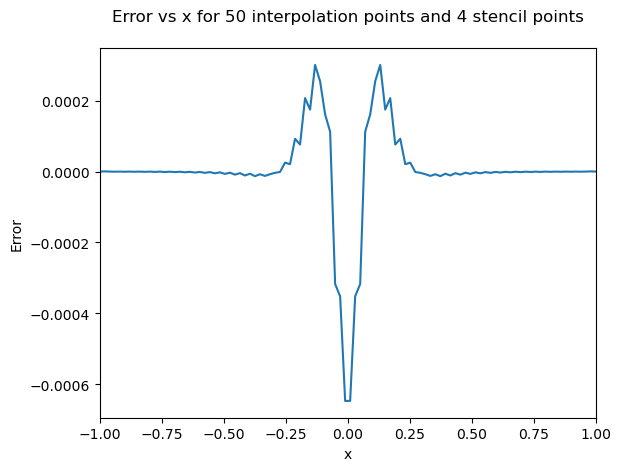

In [9]:
interp_lagrange(50)

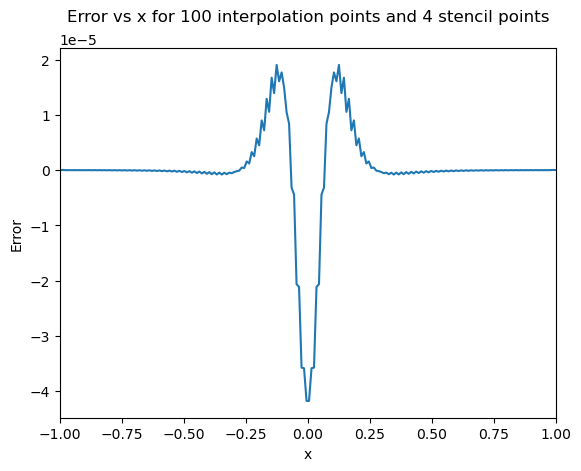

In [10]:
interp_lagrange(100)

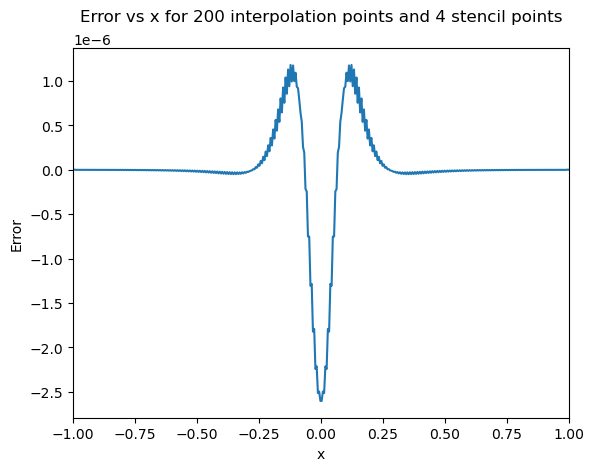

In [11]:
interp_lagrange(200)

It is pretty clear from the plots above, that the error is very small compared to the actual function shown in Fig. 1 $\\$
It is also interesting to see how error would change depending on the number of stencil points for a fixed number of interpolation points, for example, 100.

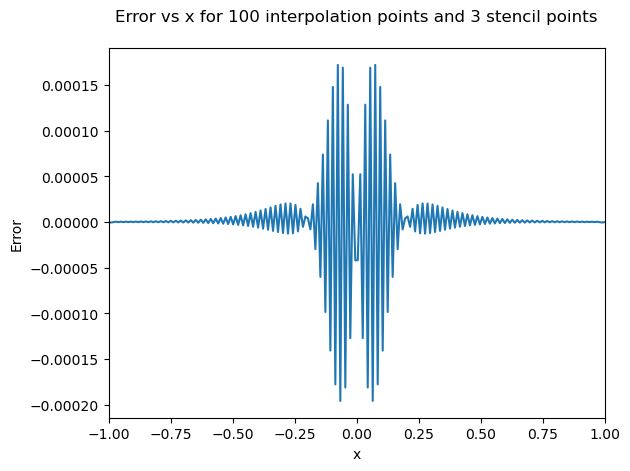

In [12]:
interp_lagrange(100, 3)

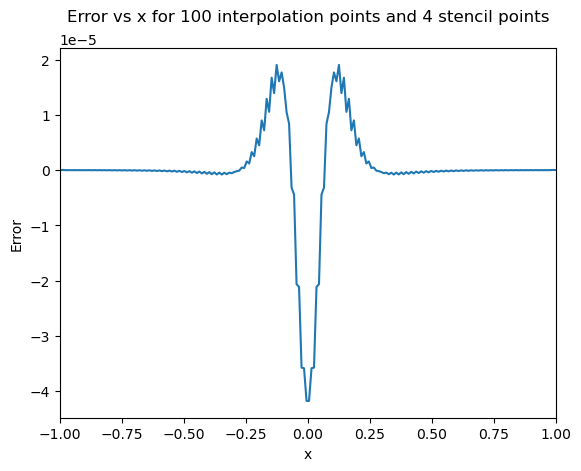

In [13]:
interp_lagrange(100, 4)

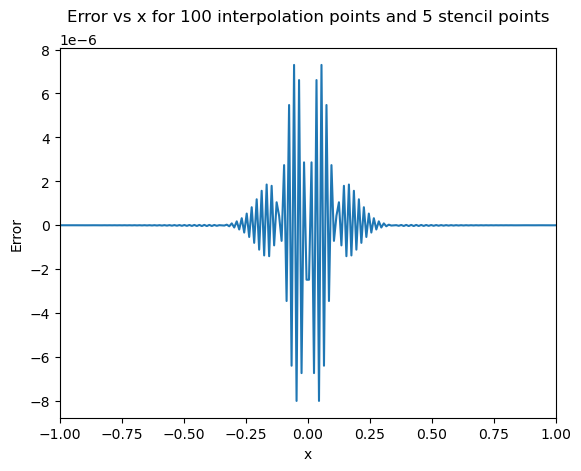

In [14]:
interp_lagrange(100, 5)

As we can see, the error tends to decrease if we use more stencil points. However, if we use too many, then error starts to increase with the number of stencil points. That could happen because all the local errors sum up, and many stencil points means more local errors from the summation. Also, this would be more expensive computationally. On the plot below, we can see that effect.

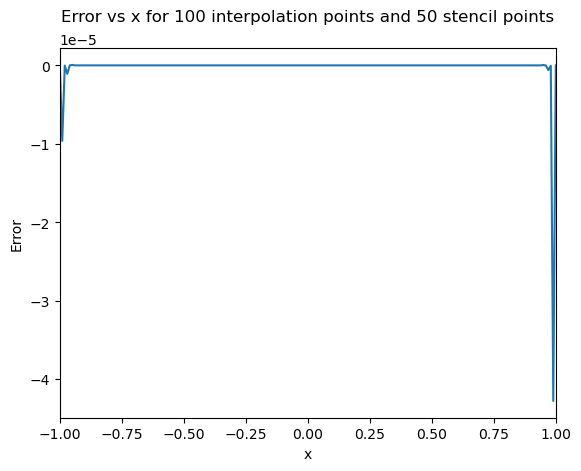

In [15]:
interp_lagrange(100, 50)

As our next step, we will explore how maximum interpolation error depends on the number of interpolation points. Function `max_error_estimator` will help us with that. Our range of $N$ values will start at 10 and end at 250. The results are shown in Fig. 2

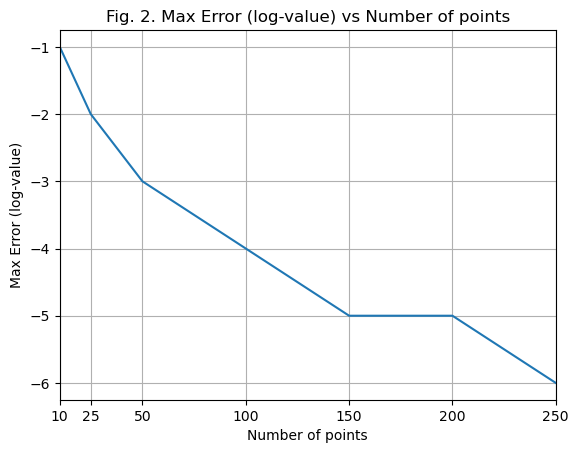

In [16]:
lagrange_N_array = [10, 25, 50, 100, 150, 200, 250]
lagrange_res_array = np.zeros_like(lagrange_N_array)
for i in range(len(lagrange_N_array)):
    lagrange_res_array[i] = np.log10(max_error_estimator(lagrange_N_array[i], 'Lagrange'))
plt.plot(lagrange_N_array, lagrange_res_array)
plt.xlim(10, 250); plt.xticks(lagrange_N_array); plt.grid(True)
plt.xlabel(r'Number of points'); plt.ylabel(r'Max Error (log-value)')
plt.title(r'Fig. 2. Max Error (log-value) vs Number of points');

As we can see, the error is decreasing with the number of interpolation points. This plot is semi-log scale. Log-error function of the number of points seems to exponentially decrease. 

# Exercise 2, Chebyshev Interpolation

In this problem, we are testing a different interpolation method - *Chebyshev expansion*. According to this method, any function on the interval $[-1, 1]$ can be expressed in the form:
$$f(x) \approx \sum_{n=0}^{N-1} c_n T_n(x)$$
Here, $T_n(x) = \cos(n \cos^{-1} x)$, also remember that $-1 \leq x \leq 1$, and $n$ is a non-negative integer. Functions `Chebyshev_polynom` and `Chebyshev_polynom_array` implement it numerically. $\\$
The most important part is to find the *weights* $c_n$ for the expansion. As a first step, we need to find *Chebyshev roots*, given by the following expression:
$$x_k = \cos(\pi\frac{2k+1}{2N}), \quad \text{where} \, k=0, 1, 2, \dots, N-1$$
Function `Chebyshev_roots` does that numerically. $\\$
Arising from the orthogonality condition:
$$\sum_{k=0}^{N-1} T_n(x_k) T_m(x_k) = 
\begin{cases} 
0 & n \neq m \\
N & n = m = 0 \\
N/2 & n = m \neq 0
\end{cases}$$
expressions for the weights are the following:
$$c_0 = \frac{1}{N} \sum_{k=0}^{N-1} f(x_k) T_0(x_k) \\
c_n = \frac{2}{N} \sum_{k=0}^{N-1} f(x_k) T_n(x_k) $$
Function `Chebyshev_weights` creates an array of weights numerically. After we calculate weights, we can do the expansion at any $x$ value in the interval $[-1, 1]$. Note, that this method does not need to define a stencil, but the user still can decide how many roots to use. Function `Chebyshev_expansion` combines all the steps of the algorithm mentioned here and produces an array of polynom expansion values. 

In [17]:
def Chebyshev_roots(nroots: int):
    '''
    Function that finds Chebyshev roots given a number of points \n
    Input: npoints (int) -  number of roots the user wants to have, must not be negative! \n
    Output: C_roots (np.array) -  array containing the roots
    '''
    if nroots < 0:
        raise ValueError(nroots, r'Number of roots nroots must not be negative!')

    C_roots = np.zeros(nroots)
    for k in range(nroots):
        C_roots[k] = np.cos(np.pi * (2 * k + 1) / (2 * nroots))
    return C_roots
    

In [18]:
def Chebyshev_polynom(x: float, n: int, diff = False):
    '''
    Function that calculates Chebyshev polynomial given a value of x and a number n \n
    Input: x (float) - variable, must be in the interval [-1, 1] \\
    n (int) - an integer number of the polynomial, must not be negative \\
    diff (bool) - if True, the function will calculate first derivative of the polynomial expression \n
    Output: T_n (float) - Chebyshev polynomial for a variable x and a number n
    '''
    if (x < -1) or (x > 1):
        raise ValueError(x, r'Variable x must be in the interval [-1, 1]!')
    if n < 0:
        raise ValueError(n, r'Number n must not be negative!')
    if diff:
        T_n = n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x ** 2)
    else: 
        T_n = np.cos(n * np.arccos(x))
    return T_n
    

In [19]:
def Chebyshev_polynom_array(x_array, n: int, diff = False):
    '''
    Function that transforms Chebyshev_polynom results into an array for an array of x values and one number n \n
    Input: x_array (np.array) - array containing x values, must not exceed the interval [-1, 1]! \\
    n (int) - an integer number of the polynomial, must not be negative \\
    diff (bool) - if True, the function will calculate first derivative of the polynomial expression \n
    Output: T_n_array (np.array) - array of the polynomials correspoding to the array of x_values
    '''
    npoints = len(x_array)
    T_n_array = np.zeros(npoints)
    for i in range(npoints):
        T_n_array[i] = Chebyshev_polynom(x_array[i], n, diff)
    return T_n_array

In [20]:
def Chebyshev_weights(x_roots, y_table):
    '''
    Function that calculates Chebyshev weights and collects them into an array \n
    Input: x_roots (np.array) - array that contains Chebyshev roots \\
    y_table (np.array) - array that contains function values at the roots \n
    Output: C_weights (np.array) - array that contains calculated weights with corresponding indexation
    '''
    nroots = len(x_roots)
    C_weights = np.zeros(nroots)
    C_weights[0] = 1 / nroots * np.sum(y_table * Chebyshev_polynom_array(x_roots, 0))
    for n in np.arange(start = 1, stop = nroots):
        C_weights[n] = 2 / nroots * np.sum(y_table * Chebyshev_polynom_array(x_roots, n))
    return C_weights


In [21]:
def Chebyshev_expansion(x_array, nroots: int, diff =  False):
    '''
    Function that calculates Chebyshev expansion of Runge's function given an array of x_values and number of roots \n
    Input: x_array (np.array) - array of x values to evaluate function over, must not exceed the interval [-1, 1]! \\
    nroots (int) - number of Chebyshev roots \\
    diff (bool) - if True, the function will be evaluating the derivative of Runge's function \n
    Output: f_exp_cheb (np.array) - resulting Chebyshev expansion of the function as an array corresponding to x_array
    '''
    f_exp_cheb = np.zeros_like(x_array)
    x_roots = Chebyshev_roots(nroots)
    y_table = runge_func(x_roots)
    C_polynom_array = np.zeros(nroots)
    for i in range(len(x_array)):
        for n in range(nroots):
            C_polynom_array[n] = Chebyshev_polynom(x_array[i], n, diff)
        f_exp_cheb[i] = np.sum(Chebyshev_weights(x_roots, y_table) * C_polynom_array)
    return f_exp_cheb

Now, we will see if the Chebyshev expansion algorithm produces smaller error than the Lagrange method, if we take 50 roots, instead of 50 Lagrange interpolation points. Results are shown in Fig. 3.

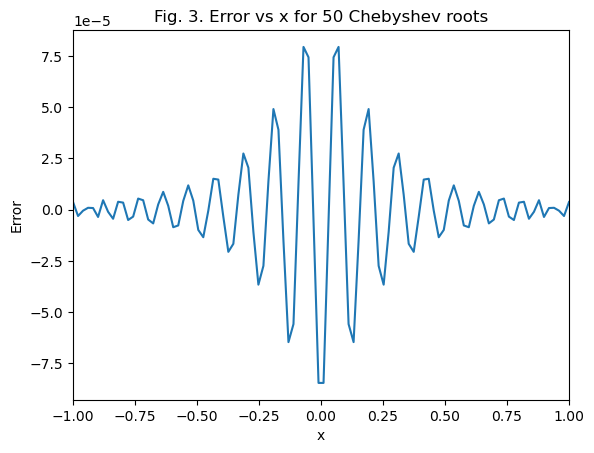

In [22]:
#test plot of error vs x, we use 50 roots here
x_test = np.linspace(-1, 1, 100)
cheb_test = Chebyshev_expansion(x_test, 50)
plt.plot(x_test, cheb_test - runge_func(x_test))
plt.xlim(-1, 1)
plt.xlabel(r'x'); plt.ylabel(r'Error')
plt.title(r'Fig. 3. Error vs x for 50 Chebyshev roots');

It is very clear, that error from Chebyshev method is smaller for at least 1 order. We will plot a maximum error vs number of roots (i. e. maximum order in Chebyshev expansion). We use `max_error_estimator function` here again. The range of number of roots is the same as for number of interpolation points for Lagrange method. Results are shown in Fig. 4. 

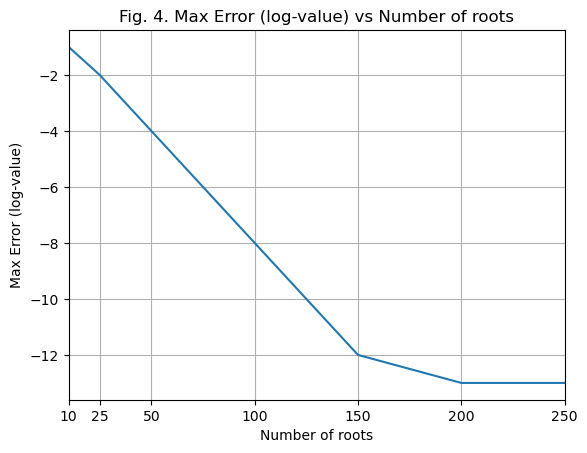

In [23]:
chebyshev_N_array = lagrange_N_array
chebyshev_res_array = np.zeros_like(chebyshev_N_array)
for i in range(len(chebyshev_N_array)):
    chebyshev_res_array[i] = np.log10(max_error_estimator(chebyshev_N_array[i], 'Chebyshev'))
plt.plot(chebyshev_N_array, chebyshev_res_array)
plt.xlim(10, 250); plt.xticks(chebyshev_N_array); plt.grid(True)
plt.xlabel(r'Number of roots'); plt.ylabel(r'Max Error (log-value)')
plt.title(r'Fig. 4. Max Error (log-value) vs Number of roots');

As expected, Chebyshev method is much more precise, and the only limitation for the user in number of roots is the computational resource. More roots would not increase the error, unless we reach a round-off error. The Log-error function also reminds an exponentially decreasing function. It decreases faster than the one shown in Fig. 2.

For the second part of this problem, we need to evaluate the derivative of Runge's function (Fig. 5):
$$f'(x) = - \frac{50x}{(25x^2+1)^2}$$


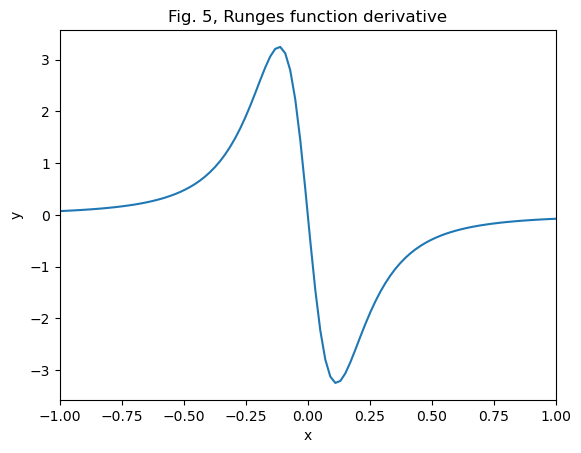

In [24]:
x_sym = symbols('x') #we need to define a symbollic variable to work with sympy and not get confused with numeric variables
runge_deriv_sym = diff(1 / (1 + 25 * x_sym**2), x_sym) #this exppression is symbollic, not suited to work with np.arrays
runge_deriv_func = lambdify(x_sym, runge_deriv_sym, 'numpy') #this line converts the symbollic expression into a numeric one, function like so we can plug an array here


x = np.linspace(-1, 1, 100)
plt.plot(x, runge_deriv_func(x))
plt.xlim(-1, 1)
plt.xlabel(r'x'); plt.ylabel(r'y')
plt.title(r'Fig. 5, Runges function derivative');

Instead of going through the whole algorithm again with the new function, we will just differentiate the expansion that we used  in the previous part. Therefore:
$$f'(x) \approx \sum_{n=0}^{N-1} c_n T_n'(x) = \sum_{n=0}^{N-1} c_n \frac{n \sin(n \cos^{-1}x)}{\sqrt{1-x^2}}$$
Note, that even though weights are derived using the original function $f(x)$, they end up just as numbers, since we do the summation. Also, the original function $f(x)$ is only going through a fixed set of points $x_k$ in the expression for deriving weights, so weights will not affect the derivative of the expansion and can be treated as constants. $\\$
In numeric functions `Chebyshev_expansion`, `Chebyshev_polynom`, and `Chebyshev_polynom_array`, parameter `diff` accounts for this part and changes the expression for the Chebyshev polynomial. However, `Chebyshev_weights` function calculates weights using the original polynomial, as it should. Therefore, to evaluate the error user just needs to input `diff = True`. In Fig. 6, we show a plot similar to the one in Fig. 3, but for the derivative of the Runge's function.

/tmp/ipykernel_60444/290501724.py:14: RuntimeWarning: invalid value encountered in double_scalars
  T_n = n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x ** 2)
/tmp/ipykernel_60444/290501724.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  T_n = n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x ** 2)
/home/askold/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


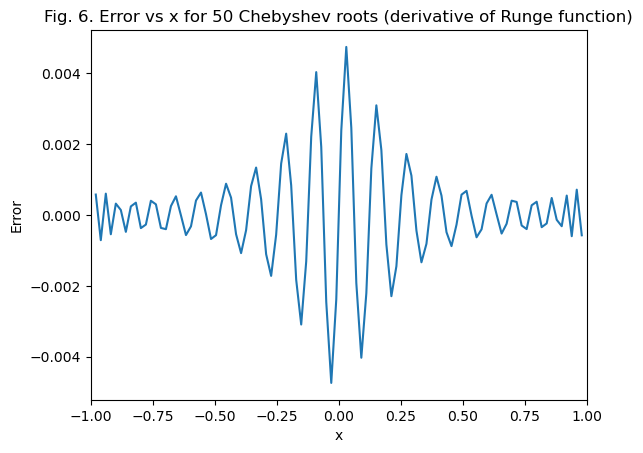

In [25]:
x_test_diff_runge = np.linspace(-1, 1, 100)
cheb_test_diff = Chebyshev_expansion(x_test_diff_runge, 50, diff=True)
plt.plot(x_test_diff_runge, cheb_test_diff - runge_deriv_func(x_test_diff_runge))
plt.xlim(-1, 1)
plt.xlabel(r'x'); plt.ylabel(r'Error')
plt.title(r'Fig. 6. Error vs x for 50 Chebyshev roots (derivative of Runge function)');

While the error has increased, it is still very small in comparison to the actual derivative values, so we still find the interpolation successful. We can also plot the maximum error vs maximum order of expansion (number of roots). The resulting plot is shown in Fig. 7 below.

/tmp/ipykernel_60444/290501724.py:14: RuntimeWarning: invalid value encountered in double_scalars
  T_n = n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x ** 2)
/tmp/ipykernel_60444/290501724.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  T_n = n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x ** 2)
/tmp/ipykernel_60444/3891238921.py:16: RuntimeWarning: invalid value encountered in multiply
  f_exp_cheb[i] = np.sum(Chebyshev_weights(x_roots, y_table) * C_polynom_array)


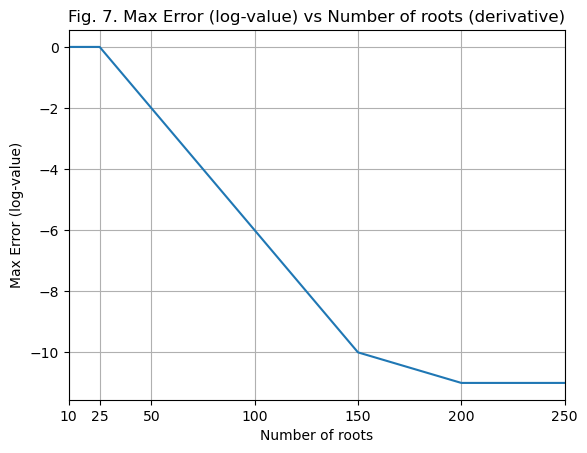

In [26]:
chebyshev_diff_N_array = lagrange_N_array
chebyshev_diff_res_array = np.zeros_like(chebyshev_diff_N_array)
for i in range(len(chebyshev_diff_N_array)):
    chebyshev_diff_res_array[i] = np.log10(max_error_estimator(chebyshev_diff_N_array[i], 'Chebyshev', diff=True))
plt.plot(chebyshev_diff_N_array, chebyshev_diff_res_array)
plt.xlim(10, 250); plt.xticks(chebyshev_diff_N_array); plt.grid(True)
plt.xlabel(r'Number of roots'); plt.ylabel(r'Max Error (log-value)')
plt.title(r'Fig. 7. Max Error (log-value) vs Number of roots (derivative)');

Chebyshev expansion still shows very good precision, despite producing erorrs of the order of 1 when less than 50 roots are used. Therefore, to evaluate the derivative with this method, user would have to use more roots than usually, no less than 50. Also, the precision is a bit lower than for a regular usage case (Fig. 4), but using about 100 or more roots would guarantee very low error. The maximum Log-error also decreases exponentially. 

## Exercise 3, Derivative Calculator

In this problem, we compute derivatives using *equal-spaced centered finite differencing*. The function we are going to use as our test function is following:
$$ f(x) = \sqrt{1-x^2}$$
We are going to numerically evaluate the derivative of this function at $x = 0.5$. The code below computes the derivative at this point with high precision, so we will compare our results with it.  

In [28]:
def test_func(x):
    '''
    Function that we use to test our derivative calculator
    '''
    return np.sqrt(1 - np.power(x, 2))

#actual derivative value that will be used as a reference point
test_func_deriv = diff(sqrt(1 - x_sym**2), x_sym)
ref_res = test_func_deriv.subs(x_sym, .5)
ref_res

-0.577350269189626

Equal-spaced centered finite differencing method allows user to evaluate the derivative with a chosen order of accuracy. The method is based on Taylor expansion of the function, so we know the order of accuracy. In general, for this method we have to choose $N+1$ points for our stencil, where $N$ is the order of accuracy. Therefore, we will have $N/2$ points to the left of the test point on $x$ axis, $N/2$ points to the right, and one central test point $x_0$. Therefore, our stencil is $\left\{x_{-N/2},\dots,x_0,\dots,x_{N/2}\right\}$. Here, $x_n = x_0 + n*h$. Note, that for this method $N$ has to be even, in other case, we will have to either skip the test point, or not have a symmetric stencil, which is contrary to method's main idea. Odd orders of accuracy are allowed for forward and backward finite difference methods. They require $N$ points to the right or left from the test point $x_0$, and do not require symmetry. $\\$
We show these methods in Fig. 8. (reference: https://en.wikipedia.org/wiki/Finite_difference#/media/File:Finite_difference_method.svg).

![Alternative-text](finite-diff_rescaled.png)
$$
\text{Fig. 8 Different types of finite differencing}
$$

For a central finite difference, we can consider an example of 1st derivative with 2nd accuracy order. In general, the derivative is defined as: 
$$ f'(x) = \frac{f(x+\Delta x) - f(x)}{\Delta x}$$ 
In the case of finite central-difference $\Delta x = 2h$, and $\Delta f(x) = f(x+h) - f(x-h)$. Thus:
$$f'(x) = \frac{f(x+h) - f(x-h)}{2h} = \frac{-\frac{1}{2}f(x-h) +\frac{1}{2}f(x+h)}{h}$$ 
We can interpret it in a way: 
$$
x_{-1} = x - h \\
x_0 = x \\
x_1 = x + h $$
Coefficients for them will be $-1/2, 0, 1/2$, respectively. To achieve higher accuracy orders, we have to use Taylor expansion and we will do that numerically.
Reference: https://en.wikipedia.org/wiki/Finite_difference; https://en.wikipedia.org/wiki/Finite_difference_coefficient

For our algorithm, user has to provide the accuracy order $N$ (must be even) and step size $h$ (should be small enough to achieve high precision), and central point $x_0$, at which the derivative will be calculated. Given the function that we are differentiating, it must exist in the differentiating interval. That is being said, user should not enter a step $h$ that will make $|x\pm Nh| > 1$ larger than 1. $(x \in [-1, 1])$ With that input, our code builds a stencil grid of $N+1$ points that are at a distance $h$ from each other, with the central point $x_0$. (Function `stencil_grid`) The next step is to calculate coefficients for the expansion at the given accuracy order. We use function `finite_diff_weights` from `sympy` package for this. After, we multiply coefficients by the values of function at corresponding points from the stencil grid and sum up the resulting array. (Function `finite_diff_central`) Our code also estimates the error. (Function `finite_diff_error`) 

In [35]:
def stencil_grid(N: int, h: float, x_0: float):
    '''
    Function that generates stencil grid given an order of accuracy, step, and test point \n
    Input: N (int) - order of accuracy, must be positive and even! \\
    h (float) - differencing step \\
    x_0 (float) - test point, must be in the interval [-1, 1]! \n
    Output: stencil_array (np.array) - stencil grid 
    '''
    if N <= 0 or N % 2 != 0:
        raise ValueError(r'Order of accuracy N must be positive and even!')
    if np.abs(x_0) > 1:
        raise ValueError(r'Test point x_0 must be in the interval [-1, 1]!')
    if x_0 - N / 2 * h < -1 or x_0 + N / 2 * h > 1:
        raise ValueError(r'Differencing step is too large, choose a smaller one, so |x_o +- N * h| does not exceed the [-1,1] interval')

    stencil_ind = np.arange(start = - N / 2, stop = N / 2 + 1)
    stencil_array = x_0 + stencil_ind * h
    return stencil_array

In [30]:
def finite_diff_central(N: int, h: float, x_0: float):
    '''
    Function that calculates the derivative of the  accuracy order N with differencing step h at the point x_0 \n
    Input: N (int) - order of accuracy, must be positive and even! \\
    h (float) - differencing step \\
    x_0 (float) - test point, must be in the interval [-1, 1]! \n
    Output: diff_res (float) - resulting derivative at the point x_0
    '''
    grid = stencil_grid(N, h, x_0)
    coeff_list = finite_diff_weights(1, grid, x0 = x_0)[1][-1] #this will calculate coefficients for 1st order derivative
    #finite_diff_weights outputs list that contains list of coefficients for different orders, so we choose [1] - first derivative
    #[1][-1]  because we want to use the last element of that list of lists (which is also list) - the last element contains coefficients for all the elements from our grid
    #output of this sympy function is a pretty confusing, cause it's list of lists of lists
    #it's easier to understand if we choose from that list as: [do][subs_i][coeff_i]
    #where do - derivative order (not to confuse with accuracy order, which is the length of the grid that we've passed - 1), 
    #subs_i - index of the subset of the grid that is used to find coefficients (-1 is the last one and this one takes the whole grid, we want that)
    #coeff_i - if we want to take a specific coefficient from this subset
    #Note: if we just pass the actual grid and test point, we will get coefficients that are already divided by the step size
    diff_res = np.sum(coeff_list * test_func(grid)) #we still need to multiply coefficients by the actual f(x) values at these points
    return diff_res

In [31]:
def finite_diff_error(N: int, h: float, x_0: float):
    '''
    Function that calculates the error of our finite differencing algorithm given the accuracy order N with differencing step h at the point x_0 \n
    Input: N (int) - order of accuracy, must be positive and even! \\
    h (float) - differencing step \\
    x_0 (float) - test point, must be in the interval [-1, 1]! \n
    Output: diff_err (float) - error of the derivative 
    '''
    x_sym = symbols('x')
    test_func_deriv = diff(sqrt(1 - x_sym**2), x_sym)
    ref_res = test_func_deriv.subs(x_sym, .5)
    diff_res = finite_diff_central(N, h, x_0)
    diff_err = np.abs(diff_res - ref_res)
    return diff_err

Now we can experiment with our code to see how the error would change if we change accuracy order $N$ or differencing step $h$. In Fig. 9, we show how the error changes depending on accuracy order with constant $h=0.01$

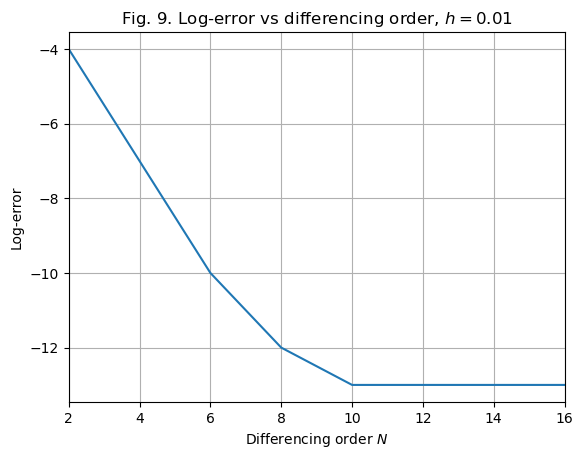

In [32]:
diff_N_test = [2, 4, 6, 8, 10, 12, 14, 16]
diff_N_test_res = np.zeros_like(diff_N_test)
for i in range(len(diff_N_test)):
    diff_N_test_res[i] = np.log10(float(finite_diff_error(diff_N_test[i], .01, .5)))
plt.plot(diff_N_test, diff_N_test_res)
plt.xlim(min(diff_N_test), max(diff_N_test)); plt.xticks(diff_N_test); plt.grid(True)
plt.xlabel(r'Differencing order $N$'); plt.ylabel(r'Log-error')
plt.title(r'Fig. 9. Log-error vs differencing order, $h=0.01$');

As we can see, even at the second accuracy order, the error is of an order $10^{-4}$, and it decreases even more when we reach higher orders. However, after reaching 10th accuracy order, the error stays the same, so using higher orders will not be beneficial. Our next test is how the error will change depending on the differencing step $h$ at the second accuracy order. (Fig. 10)

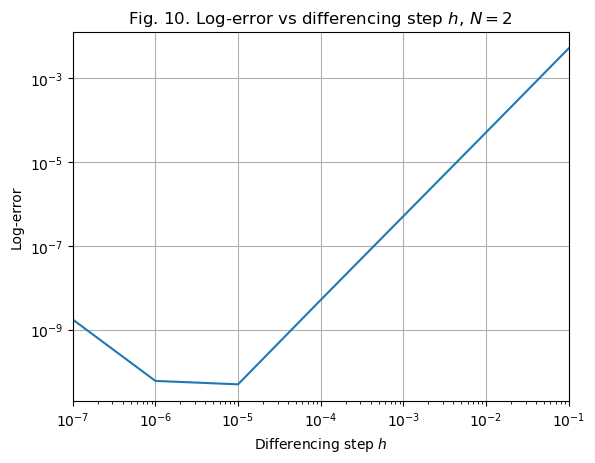

In [33]:
diff_h_test = np.power(1e1, -1 * (np.arange(7) + 1))
diff_h_test_res = np.zeros_like(diff_h_test)
for i in range(len(diff_h_test)):
    diff_h_test_res[i] = float(finite_diff_error(2, diff_h_test[i], .5))
plt.loglog(diff_h_test, diff_h_test_res)
plt.xlim(min(diff_h_test), max(diff_h_test)); plt.grid(True)
plt.xlabel(r'Differencing step $h$'); plt.ylabel(r'Log-error')
plt.title(r'Fig. 10. Log-error vs differencing step $h$, $N=2$');

Error increases, as we increase the differencing step. However, if we make the step $h$ too small, the error would increase too, probably, because of the round-off. Therefore, it is important to not pass that threshold. Also, this would depend on the test point and function. In order to achieve best precision, one should find an error minimum for the specific problem.